In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0
!pip install tfp-nightly==0.7.0.dev20190519


## Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

%matplotlib inline

from google.colab import files

from sklearn.model_selection import train_test_split


In [3]:
print(tf.__version__)
print(tfp.__version__)

2.0.0-alpha0
0.7.0-dev20190519


## Simulate the fish data

In [4]:
x1=np.arange(1,12,0.15)
x1=x1[::-1]
print(len(x1))
x2=np.repeat(1,20)
print(len(x2))
x3=np.arange(1,15,0.1)
x4=np.repeat(15,30)
print(len(x3))
x5=x3[::-1]
print(len(x4))
x6=np.repeat(1,20)
#x5=np.arange(0,20,0.02)
#print(len(x5))
#x6=x5[::-1]
#x7=np.repeat(0,20)

#x=np.concatenate([x1,x2,x3,x4,x5,x6,x7])

x=np.concatenate([x1,x2,x3,x4,x5,x6])


74
20
140
30


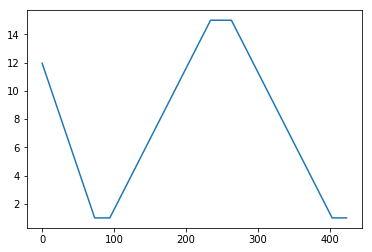

In [5]:
plt.plot(x)

In [6]:
print(len(x))

424


In [0]:
np.random.seed(4710)
noise=np.random.normal(0,x,len(x))

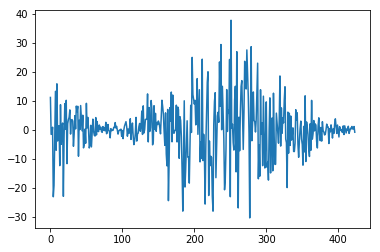

In [8]:
plt.plot(noise)

In [9]:
print(len(x))#anz punkte

424


In [0]:
np.random.seed(99)
first_part=len(x1)
x11=np.random.uniform(-1,1,first_part)
np.random.seed(97)
x12=np.random.uniform(1,6,len(noise)-first_part)
x=np.concatenate([x11,x12])

In [0]:
x=np.sort(x)

In [0]:
y=2.7*x+noise

In [0]:
y=y.reshape((len(y),1))
x=x.reshape((len(x),1))

x_all = x
y_all = y

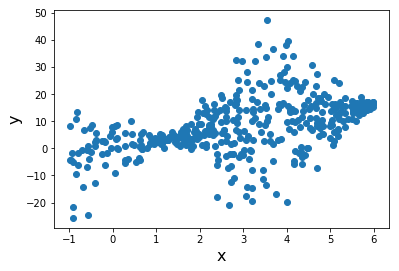

In [14]:
plt.scatter(x,y)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.show()

### Split data in train and test

In [0]:
X=x
Y=y

In [16]:

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=47)
len(x_test)

106

In [0]:
x = x_train
y = y_train


Text(0.5, 1.0, 'train data')

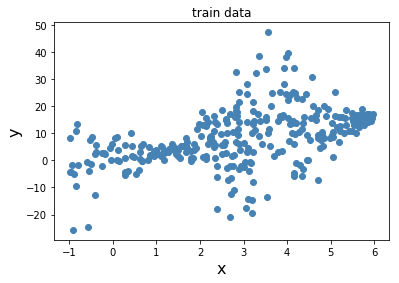

In [18]:
#plt.figure(figsize=(10,10))
plt.scatter(x,y,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.title("train data")
#plt.savefig("fish_train.pdf")
#files.download("fish_train.pdf")

In [0]:

np.savetxt('fish_train_x.out', (x))
files.download('fish_train_x.out')
np.savetxt('fish_train_y.out', (y))
files.download('fish_train_y.out')

Text(0.5, 1.0, 'test data')

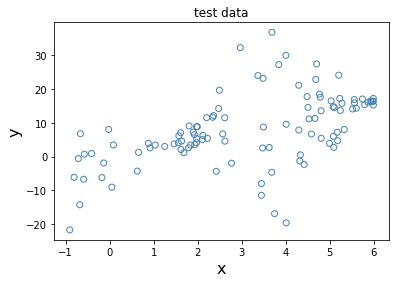

In [19]:
plt.scatter(x_test,y_test,facecolors='none', edgecolors="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.title("test data")
#plt.savefig("fish_test.pdf")
#files.download("fish_test.pdf")

In [0]:
np.savetxt('fish_test_x.out', (x_test))
files.download('fish_test_x.out')
np.savetxt('fish_test_y.out', (y_test))
files.download('fish_test_y.out')

## Fit linear regression with constant variance

In [0]:
def NLL(y, rv_y):
  return -rv_y.log_prob(y) #A

In [0]:
# without tfp
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1,input_shape=(1,)))
model.compile(loss='mse',                    #A
         optimizer="adam", metrics=['accuracy'])

#A call the standard Keras loss MSE 


In [22]:
model.fit(x,y,batch_size=16,epochs=2000,verbose=0)

Text(0, 0.5, 'y')

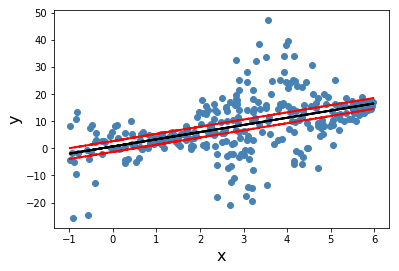

In [23]:
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x,model.predict(x),color="black",linewidth=2)
plt.plot(x,model.predict(x)+2,color="red",linestyle="--",linewidth=2)
plt.plot(x,model.predict(x)-2,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
#plt.savefig("fish_2.pdf")
#files.download("fish_2.pdf")

## Fit linear regression allow the sd to depend in a monotonic way on the input

In [0]:
def NLL(y, rv_y):
  return -rv_y.log_prob(y) #A

In [0]:
# montonic sd change
model = tf.keras.Sequential() 
model.add(tf.keras.layers.Dense(2,input_shape=(1,))) #B
model.add(tfp.layers.DistributionLambda(  
        lambda t: tfd.Normal(loc=t[:,0:1], #C
        scale=1e-3 + tf.math.softplus(0.05 * t[:,1:2])))) #D
model.compile(optimizer=tf.optimizers.Adam(), loss=NLL) 



In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit(x, y, epochs=1000, verbose=0)

Text(0, 0.5, 'y')

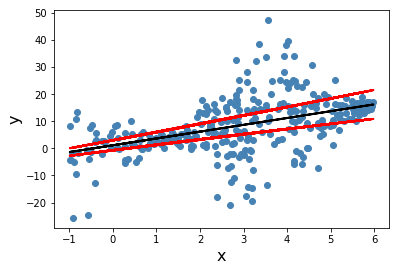

In [32]:
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x,model(x).mean(),color="black",linewidth=2)
plt.plot(x,model(x).mean()+2*model(x).stddev(),color="red",linestyle="--",linewidth=2)
plt.plot(x,model(x).mean()-2*model(x).stddev(),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
#plt.savefig("fish_3.pdf")
#files.download("fish_3.pdf")

Text(0.5, 1.0, 'test data')

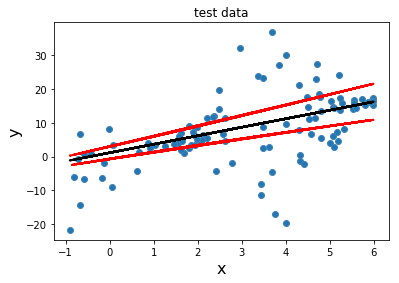

In [33]:
# test data
plt.scatter(x_test,y_test,edgecolors="steelblue") #observerd 
plt.plot(x_test,model(x_test).mean(),color="black",linewidth=2)
plt.plot(x_test,model(x_test).mean()+2*model(x_test).stddev(),color="red",linestyle="--",linewidth=1)
plt.plot(x_test,model(x_test).mean()-2*model(x_test).stddev(),color="red",linestyle="--",linewidth=1)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("test data")
#plt.savefig("fish_3.pdf")
#files.download("fish_3.pdf")

In [0]:
mean_test_b = model(x_test).mean()
sd_test_b = model(x_test).stddev()


In [0]:
mean_test_b
np.savetxt('mean_test_b.out', (mean_test_b))
files.download('mean_test_b.out')
np.savetxt('sd_test_b.out', (mean_test_b))
files.download('sd_test_b.out')

## Fit a linear regression and allow the sd to depend in a flexible manner on the input

In [0]:
def NLL(y, rv_y):
  return -rv_y.log_prob(y) #A

In [0]:

inputs = Input(shape=(1,))
out1 = tf.keras.layers.Dense(1)(inputs)
hidden1 = tf.keras.layers.Dense(20,activation="relu")(inputs)
hidden2 = tf.keras.layers.Dense(10,activation="relu")(hidden1)
out2 = tf.keras.layers.Dense(1)(hidden2)
out = tf.keras.layers.Concatenate()([out1,out2])
predictions = tfp.layers.DistributionLambda(lambda t: 
     tfd.Normal(loc=t[:, 0:1],
     scale=1e-3 + tf.math.softplus(0.05 * t[:,1:2])))(out)
model2 = Model(inputs=inputs, outputs=predictions)
model2.compile(optimizer=tf.optimizers.Adam(), loss=NLL)


In [36]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 20)           40          input_1[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 10)           210         dense_4[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1)            2           input_1[0][0]                    
______________________________________________________________________________________________

In [37]:
model2.fit(x,y,epochs=4000,verbose=0)



In [38]:
model2.evaluate(x,y)#should be around 3.1
#if not train longer

318/318 [==============================] - 0s 200us/sample - loss: 3.1940


3.194048596628057

In [41]:
x_val = np.linspace(-1,6,50)
x_val = x_val.reshape((50,1))
x_val.shape, x.shape

((50, 1), (318, 1))

In [40]:
# for extrapolation
#x_val = np.linspace(-5,10,50)
#x_val = x_val.reshape((50,1))
#x_val.shape, x.shape

((50, 1), (318, 1))

Text(0, 0.5, 'y')

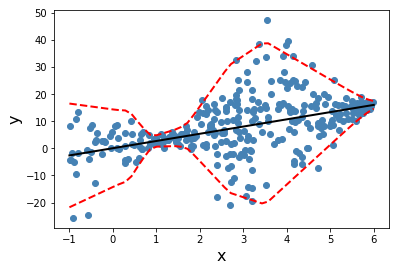

In [42]:
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x_val,model2(x_val).mean(),color="black",linewidth=2)
plt.plot(x_val,model2(x_val).mean()+2*model2(x_val).stddev(),color="red",linestyle="--",linewidth=2)
plt.plot(x_val,model2(x_val).mean()-2*model2(x_val).stddev(),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
#plt.savefig("fish_4.pdf")
#files.download("fish_4.pdf")

In [0]:
mean_test = model2(x_test).mean()
sd_test = model2(x_val).stddev()
#print(mean_test)



In [0]:
np.savetxt('test.out', (mean_test))
from google.colab import files
files.download('test.out')